# Identifying Invalid GPS Points in Taxi Trips

This notebook explores automatically detecting invalid GPS points in taxi trip data from
Porto, Portugal. My goal was to determine a somewhat systematic method of doing so; the 
approach that I converged on was to model the movement of a taxi as a random walk and
approximate the likelihood of each coordinate pair given the other coordinate pairs in
a sequence.

To speed up the process of investigation, I only used the first 1000 rows of the data set
and assumed that it was representative of the rest of the data. After doing the analysis,
I discovered that this might not be true (in particular, there are a couple long trips in
later segments). However, I think 1000 examples is large enough that the analysis still
holds enough to demonstrate the concept.

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import LineString, Point

def load_data(fname, nrows):
    df = pd.read_csv(fname, nrows=nrows)
    df['traj'] = json.loads('[' + df.POLYLINE.str.cat(sep=',') + ']')
    df = df[df.traj.str.len() > 1].copy()
    df['lines'] = gpd.GeoSeries(df.traj.apply(LineString))
    return gpd.GeoDataFrame(df, geometry='lines')

df = load_data('train.csv', nrows=None)
df.head()

Each row of the dataset contains taxi information and trajectories for that taxi. The coordinates in the trajectories are evenly spaced by 15 second intervals.

In [ ]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15,8]
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

df.lines.plot(figsize=[15,15]);
plt.xlabel('Longitude')
plt.ylabel('Latitude');

Already we can see the existence of inconsistent data&mdash;there are huge discontinuities in the taxi routes, probably due to outliers or a misunderstanding of how the data was collected. Let's look at a particular instance of this:

In [ ]:
df.iloc[[2]].lines.plot(figsize=[15,15]);
plt.xlabel('Longitude')
plt.ylabel('Latitude');

In [ ]:
df.iloc[[3]].lines.plot(figsize=[15,15]);
plt.xlabel('Longitude')
plt.ylabel('Latitude');

From what I know about taxis, these routes clearly have discontinuities. Let's first try to characterize outliers so that we can detect them automatically. To get a feel for how much the "speed" at the discontinuities is out of character for the trip, let's look at the empirical distribution function of speeds in the trip.

In [ ]:
from sklearn.metrics import DistanceMetric
metric = DistanceMetric.get_metric('haversine')
def haversine(x):
    return metric.pairwise(np.radians(x)[:,::-1])
R = 6371 # radius of earth in km
dt = 15/3600 # coordinates are reported in 15 second intervals

def velocities(coords):
    return R/dt*np.diag(haversine(coords)[1:])

def plot_cdf(ax, values, xlabel, logscale=False):
    ax.set_ylabel('F(x)')
    ax.set_xlabel(xlabel)
    sns.lineplot(ax=ax, x=np.sort(values), y=np.arange(1,len(values)+1)/len(values), palette='tab10')
    if logscale:
        plt.xscale('log')

fig, ax = plt.subplots()
plot_cdf(ax, velocities(df.traj[2]), 'Speed (km/h)')
plot_cdf(ax, velocities(df.traj[3]), 'Speed (km/h)')

As expected, the speed is *significantly* out of character with the rest of the speeds in the trip.
A simple algorithm to detect invalid GPS data is would be to set a threshold, say at 200 km/hr, and hope that it catches most of the bad routes in the dataset. Before we do that, however, let's look more closely at the pairwise distances between GPS coordinates. Specifically, let's plot the velocities between points as the distances increases.

In [ ]:
def velocity_graph(ax, coords):
    n = len(coords)
    dist = haversine(coords)
    interval = dt*np.abs(np.arange(n)[:,None] - np.arange(n)).clip(1)
    vel = R*dist/interval
    sns.heatmap(vel, ax=ax, square=True, robust=True)
    ax.set_title('Velocity (km/h)')
    ax.set_xlabel('GPS Sample Index')
    ax.set_ylabel('GPS Sample Index')

fig, axes = plt.subplots(1, 2, figsize=[25,10])
fig.suptitle("Average Velocities Between GPS Samples")
velocity_graph(axes[0], df.traj[2])
velocity_graph(axes[1], df.traj[3])

In [ ]:
df.iloc[[2,3]].plot(figsize=[15,15]);
plt.xlabel('Longitude')
plt.ylabel('Latitude');

Ok, this visualization makes it extremely obvious which GPS coordinates are a problem. Just to double check let's try to find some routes that don't have any problems.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=[25,10])
velocity_graph(ax[0], df.traj[45])
velocity_graph(ax[1], df.traj[39])

In [ ]:
df.iloc[[45,39]].plot(figsize=[15,15]);
plt.xlabel('Longitude')
plt.ylabel('Latitude');

Ok, these seem like "normal" routes. So we seem to have a heuristic way to identify bad GPS points (i.e. look at pairwise velocities). How can we characterize them systematically? One thought is to use information about the road network. If a taxi appears to cross major highways, it is more likely an error in the GPS coordinates.

But is there a way to detect them without using this side information? Consider what the images represent: the average velocity between two points in time. In other words, it is the distance between points normalized by the time it required to reach that point. If the taxi were always traveling in a straight line, this would be equal to the average (instantaneous) speed of the taxi between those points. However, the taxi has rather erratic behavior, actually. In fact, what if we consider the taxi routes to be random walks? First, let's confirm this by considering the distribution of distances between points.

In [ ]:
def offset_distances(coords, offset):
    dist = R*haversine(coords)
    dists = np.diag(dist[offset:])
    return dists

def plot_dists(ax, di):
    dists = np.hstack(df.traj.apply(lambda x: offset_distances(x, di)).values)
    sns.distplot(dists, ax=ax, kde=False, bins=300)
    ax.set_title('Time Offset: {} min'.format(di*dt*60))
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Count')

fig, axes = plt.subplots(2,2, figsize=[20,17])
plot_dists(axes[0,0], 1)
plot_dists(axes[0,1], 10)
plot_dists(axes[1,0], 40)
plot_dists(axes[1,1], 100)

These distribution plots show some interesting behavior. First, there are a lot of pairs of points with approximately 0 distance from each other. Second, once the time between GPS samples is about 10 minutes, it reaches a static equilibrium. Until that, it seems to match a Rayleigh distribution fairly well (i.e. the magnitude of a gaussian distribution). A simple estimate of the standard deviation of the gaussian process is given by $$\hat{\sigma}^2 = \frac{1}{2N}\sum_{i=1}^N x_i^2.$$ Let's look at this (or the square root of it, since it's more intuitive) as a function of time: 

In [ ]:
def dist_sequence(coords):
    n = len(coords)
    dist = R*metric.pairwise(np.radians(coords)).ravel()
    offsets = (np.arange(n)[:,None] - np.arange(n)).ravel()
    return pd.DataFrame([offsets[offsets>0]*dt*60,dist[offsets>0]], index=['time_offset', 'distance']).T

dist_ungrouped = pd.concat(df.traj.apply(dist_sequence).values).set_index('time_offset')

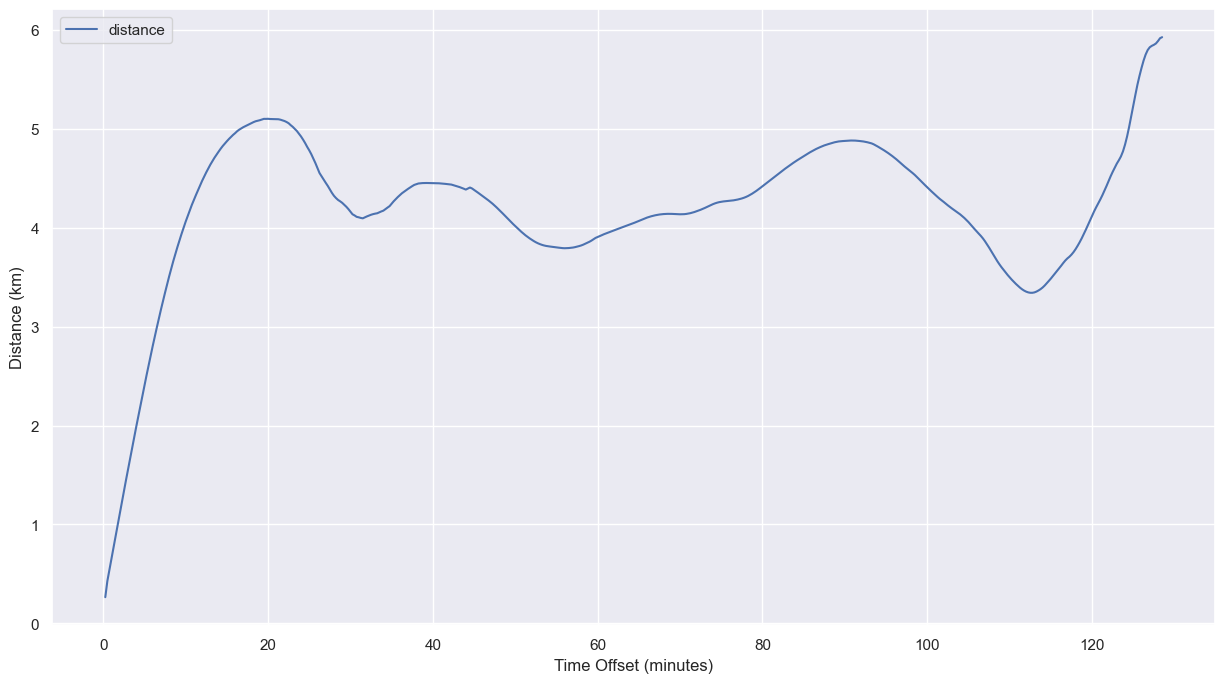

In [ ]:
dists = np.sqrt((dist_ungrouped**2).groupby('time_offset').mean()/2)
sns.lineplot(data=dists)
plt.xlabel('Time Offset (minutes)')
plt.ylabel('Distance (km)');

The above plot approximates the standard deviation of an underlying 2-dimensional normal distribution. Intuitively, it represents the average distance between GPS points as the time offset increases. After about 10-20 minutes, the distance stabilizes. This makes sense: taxis generally only service a region of limited length; in this case, a region of about 5 km.

From a modeling standpoint, we mostly care about the first 10 minutes. Let's zoom in on this section and fit a rational function to it, $$y=\frac{ax}{x+b},$$ which is equivalent to minimizing $$C = \sum_i (ax_i - x_iy_i - by_i)^2.$$
This is easy to do by using `lstsq` in `numpy`.

a: 4.879607528246523
b: 4.9028831689567935
a/b: 0.9952526625848148


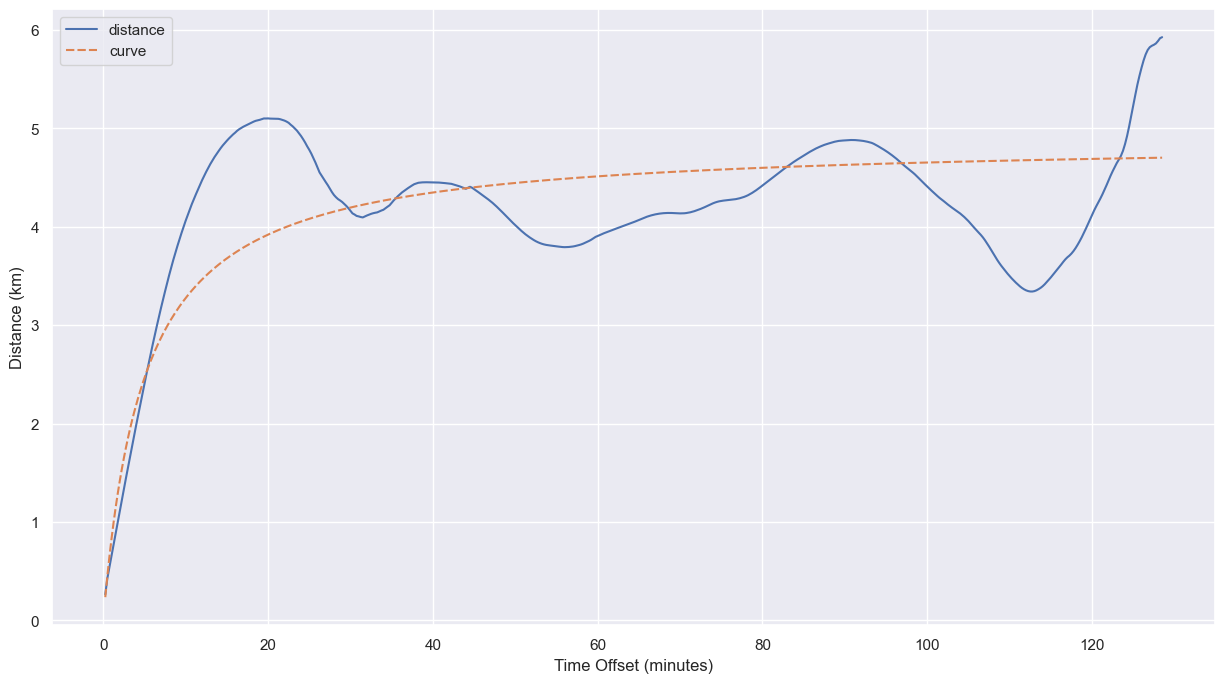

In [ ]:
def fit_rational(x,y,w=1):
    ws = np.sqrt(w)
    (a,b),_,_,_ = np.linalg.lstsq(np.column_stack([x,-y])*ws[:,None], x*y*ws, rcond=None)
    return a*x/(x+b), (a,b)

dists['curve'], coeffs = fit_rational(dists.index.values, dists.distance.values, ((1+np.arange(len(dists)))/(1+len(dists)))**-3)
print('a:', coeffs[0])
print('b:', coeffs[1])
print('a/b:', coeffs[0]/coeffs[1])
sns.lineplot(data=dists);
plt.xlabel('Time Offset (minutes)')
plt.ylabel('Distance (km)');

That looks fairly good. I'll be honest, the weights $w_i = (n+1)^3/(i+1)^3$ were arbitrarily chosen to indicate that we care more about the shape of the curve for small time offsets than later on. Furthermore, observe that the inital slope of the line is given by $a/b$ and the limiting value as $t\to\infty$ is given by $a$. The value of $b$ gives a good idea of where the "elbow" of the function exists. For example,
\begin{aligned}
\alpha &= \frac{x}{x+b} \\
\alpha x + \alpha b &= x \\
\left(\frac{\alpha}{1-\alpha}\right)b &= x \\
\end{aligned}
indicates the value of $x$ where the function has reached $\alpha$ of it's maximum value. Let's define the elbow as the value where $\alpha=0.8$; i.e. $x_0=4b$. In the above case, the elbow is at a time offset of approximately 20 minutes. This is a useful quantity because it indicates the amount of time that we can consider the GPS points in a particular taxi route to be correlated.

So how can we use this to detect invalid GPS coordinates? We can frame this using Bayesian probability as such: let $x_i$ be a location in a route, and $r_i$ be the rest of the locations in that route. Apply Bayes Rule: $$P(x_i | r_i) = \frac{P(r_i | x_i) P(r_i)}{P(x_i)} .$$ Assume that $P(x_i)$ and $P(r_i)$ are constant for a particular route. Furthermore, assume $P(x_{j\ne i} | x_i)$ are independent (a naive Bayes). Then:
\begin{aligned}
\log{P(x_i | r_i)} &= C + \sum_{j \ne i} \log P(x_j | x_i) \\
 &= C + \sum_{j \ne i} \frac{-d(x_i,x_j)^2}{2\sigma_{ij}^2} - \log \sigma_{ij} , \\
 \end{aligned}
 where $C$ absorbs constant offsets and $\sigma_{ij}$ is the standard deviation of the random walk distances (estimated by the curve shown above)
 . Clearly, this is maximized when $\forall i \ne j, \, d(x_i,x_j) =0$ (the taxi never moves). Define the log-likelihood ratio as $$LR(x_i | r_i) = -\frac{1}{2}\sum_{j \ne i} \frac{d(x_i,x_j)^2}{\sigma_{ij}^2} .$$
 This quantity estimates the probability of the rest of the taxi's route given a single location, divided by the probability of a route where it never moves. Let's try this out for a couple routes.

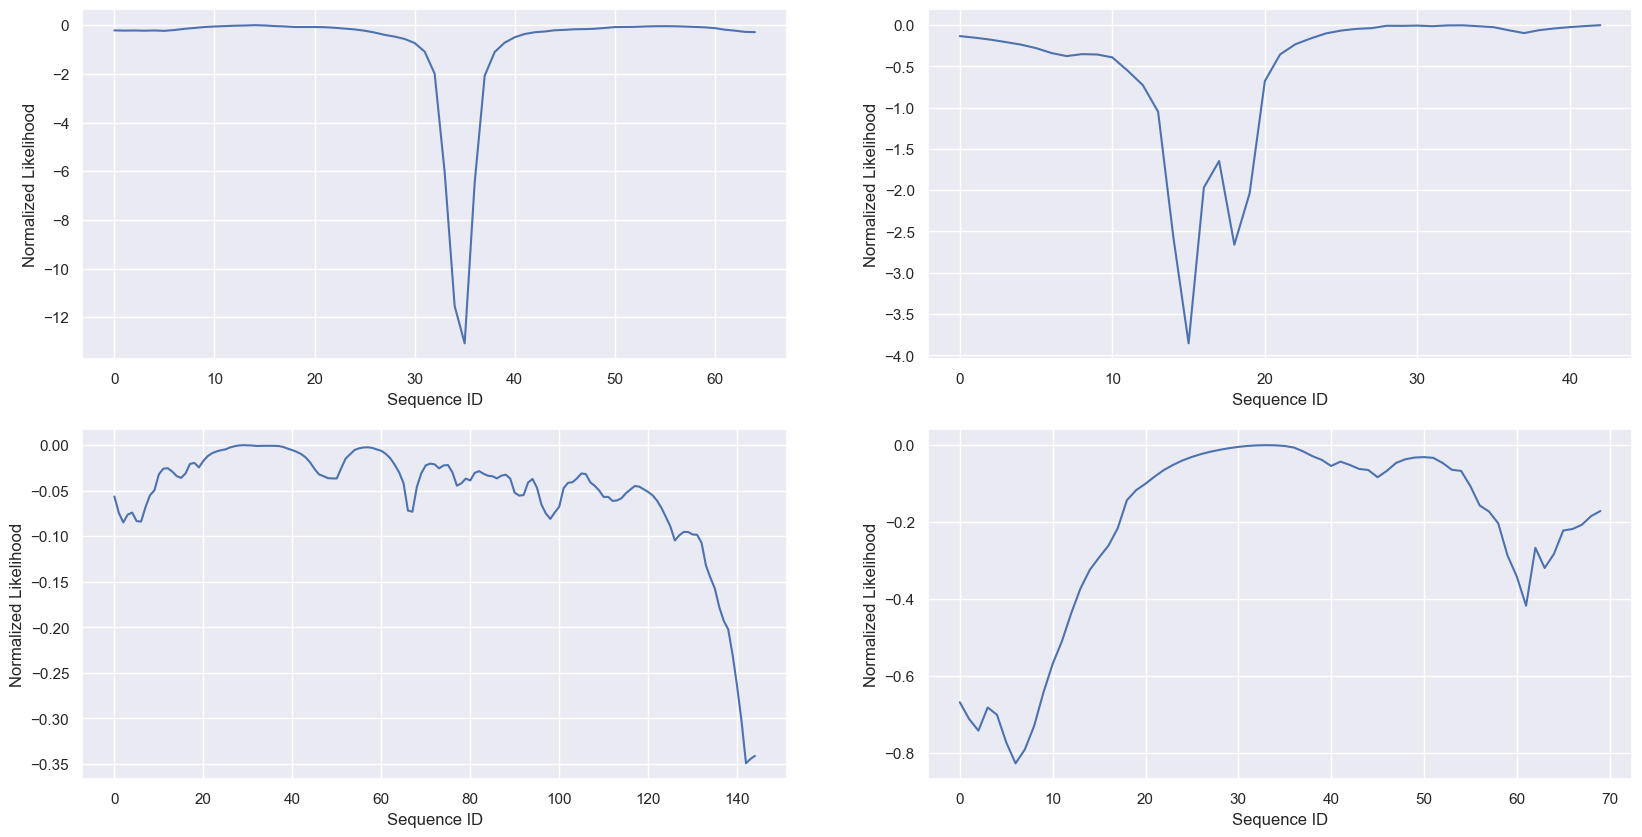

In [ ]:
index = 1
def likelihood(coords, ab):
    print(index)
    index = index + 1
    n = len(coords)
    a,b = coeffs
    dist = R*metric.pairwise(np.radians(coords))
    time = dt*60*np.abs(np.arange(n)[:,None] - np.arange(n))
    sigma = a*time/(time + b) + np.eye(n)
    lr = -0.5*(dist**2/sigma**2).sum(axis=1)
    return lr

def norm_lr(lr):
    return (lr-lr.max())/len(lr)

def plot_likelihood(ax, coords):
    lr = likelihood(coords,coeffs)
    lr = norm_lr(lr)
    sns.lineplot(x=np.arange(len(coords)),y=lr, ax=ax);
    ax.set_xlabel('Sequence ID')
    ax.set_ylabel('Normalized Likelihood')

fig,ax = plt.subplots(2,2, figsize=[20,10])
plot_likelihood(ax[0,0], df.traj[2])
plot_likelihood(ax[0,1], df.traj[3])
plot_likelihood(ax[1,0], df.traj[45])
plot_likelihood(ax[1,1], df.traj[39])

Let's see if we can use this to detect routes with invalid GPS points.

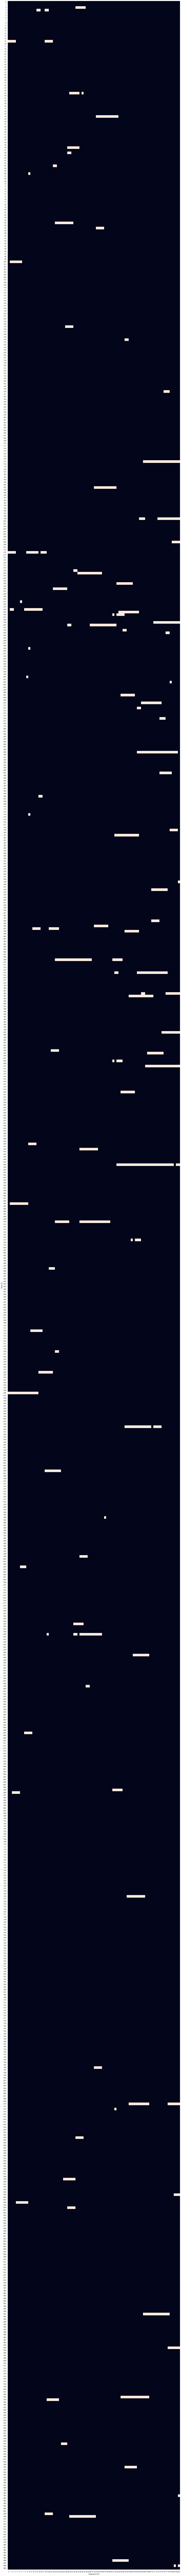

In [ ]:
n = int(df.traj.str.len().quantile(0.9))
thresh = -2
invalid = df.traj.apply(lambda t: (norm_lr(likelihood(t,coeffs)) < thresh)[:n].tolist() + [False]*(n-len(t))).values.tolist()
plt.figure(figsize=[20,300])
sns.heatmap(data=invalid, cbar=False);
plt.xlabel('Sequence ID')
plt.ylabel('Row ID');

In [ ]:
bad_routes = df.traj.apply(lambda t: (norm_lr(likelihood(t,coeffs)) < thresh).any()).values
print("Routes with invalid points: {} / 1000".format(bad_routes.sum()))

Routes with invalid points: 116 / 1000


About 10% of routes have been detected to have invalid GPS coordinates. That's a lot, in my opinion! Time for some spot checking.

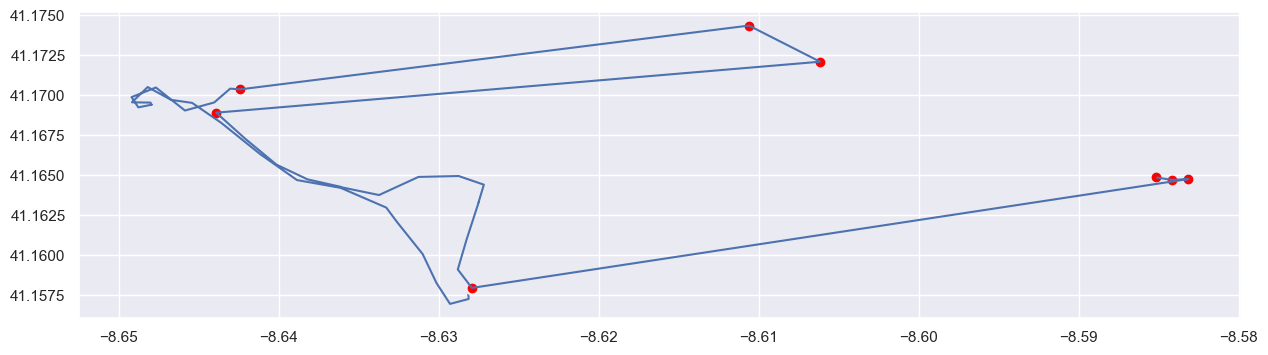

In [ ]:
def spot_check(i):
    coords = np.array(df.iloc[i].traj)
    bad = norm_lr(likelihood(coords, coeffs)) < thresh
    df.iloc[[i]].plot()
    plt.scatter(x=coords[bad,0],y=coords[bad,1], color='red')
    plt.show()
spot_check(15)

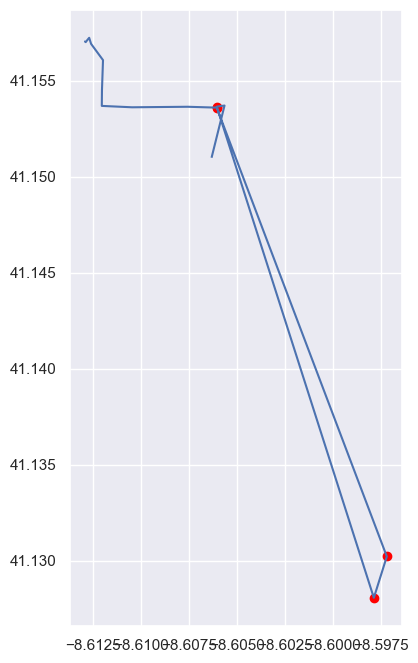

In [ ]:
spot_check(690)

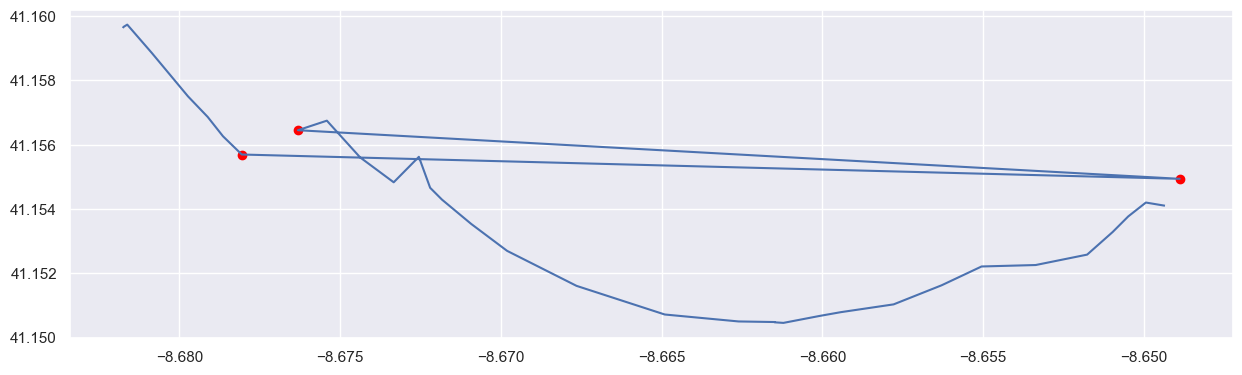

In [ ]:
spot_check(941)

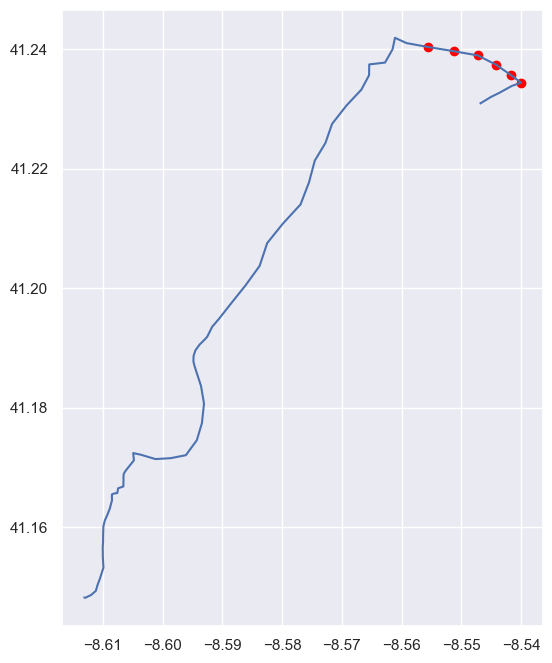

In [ ]:
spot_check(848)

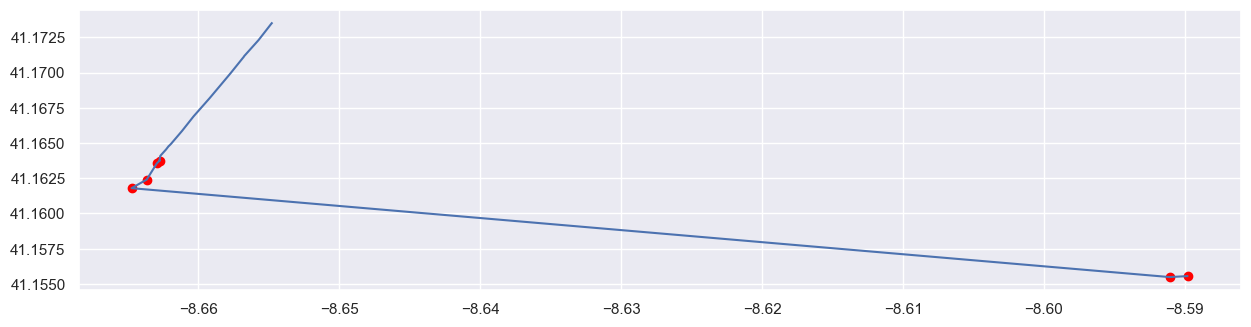

In [ ]:
spot_check(924)

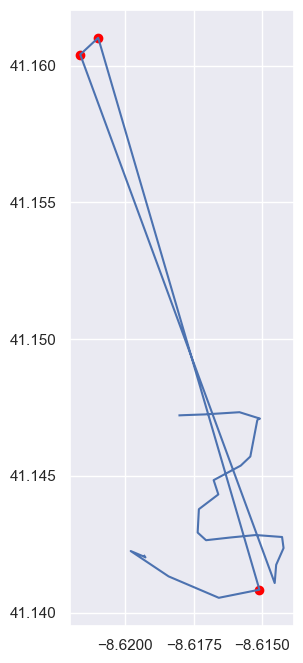

In [ ]:
spot_check(603)

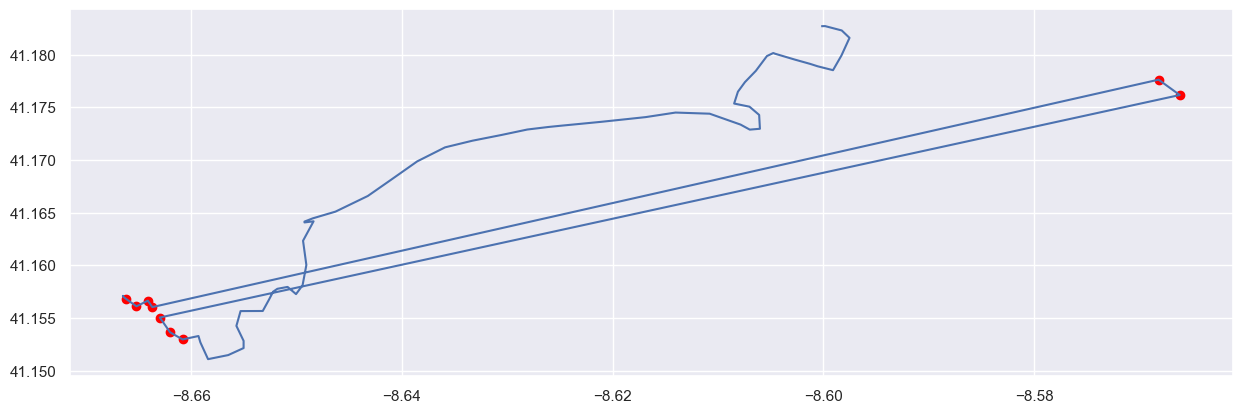

In [ ]:
spot_check(730)

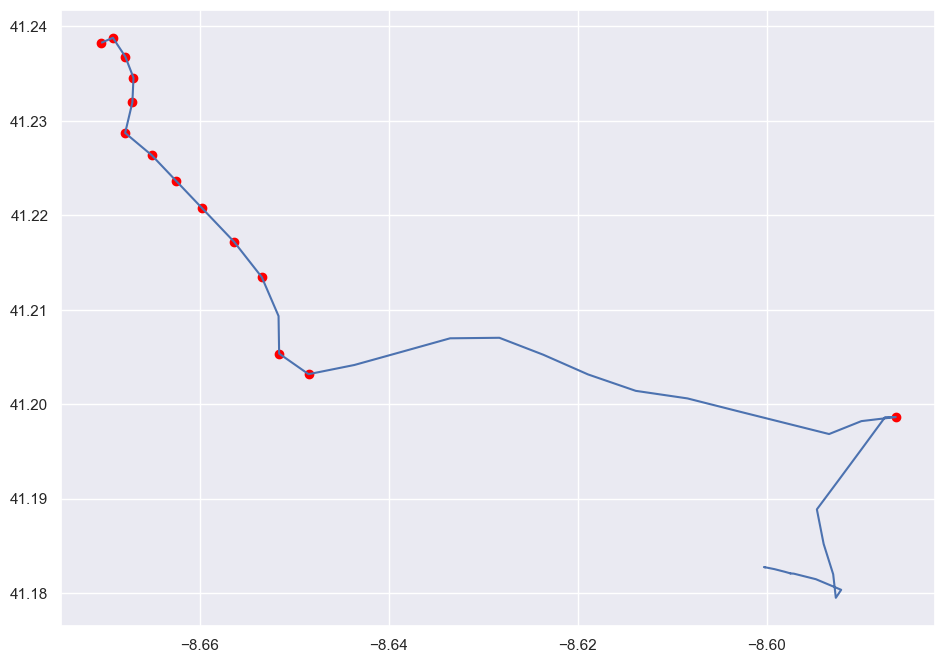

In [ ]:
spot_check(629)

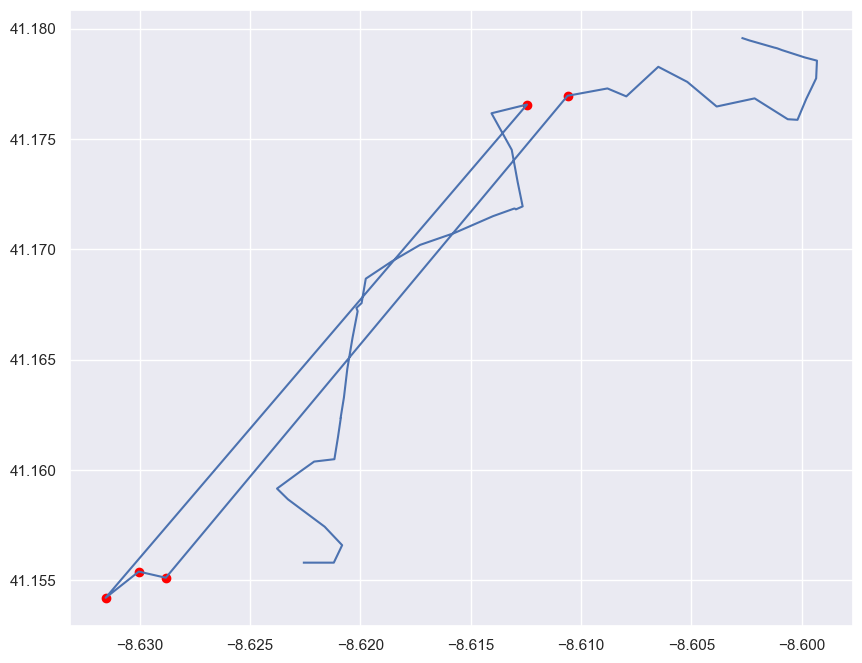

In [ ]:
spot_check(625)

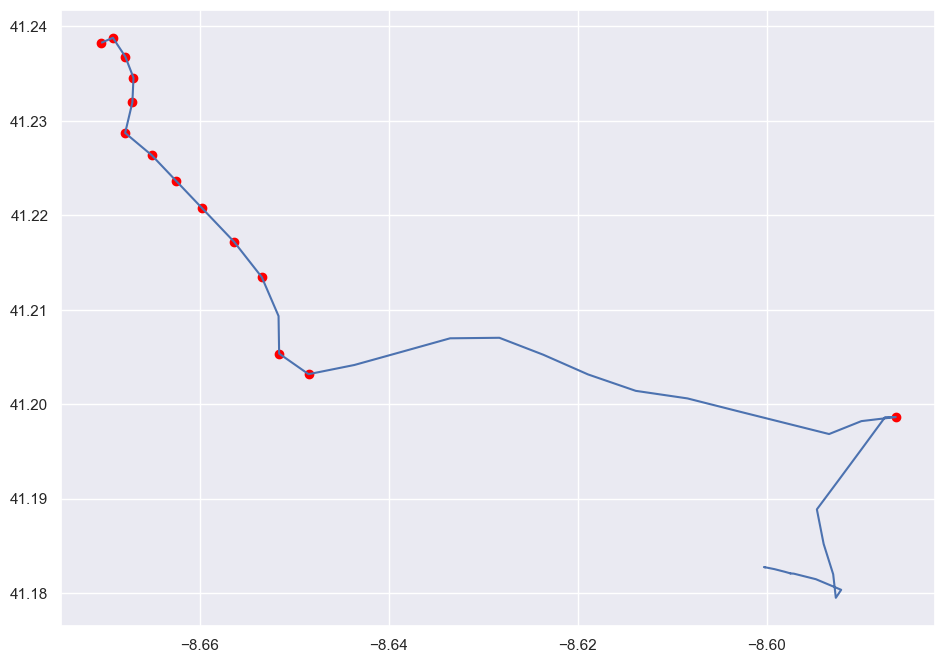

In [ ]:
spot_check(629)

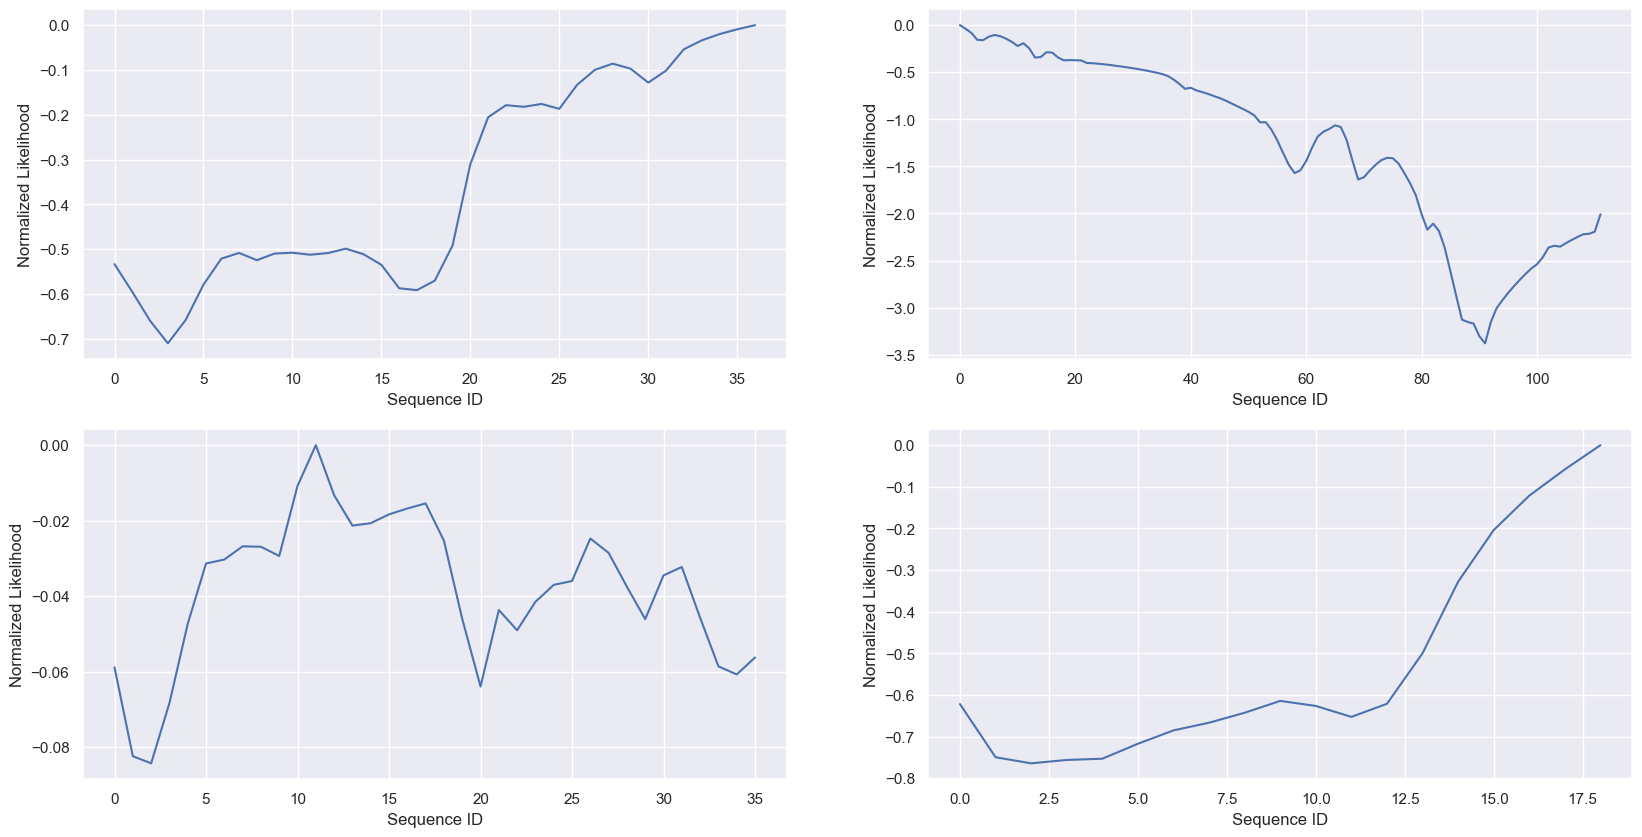

In [ ]:
fig,ax = plt.subplots(2,2, figsize=[20,10])
plot_likelihood(ax[0,0], df.traj[357])
plot_likelihood(ax[0,1], df.traj[212])
plot_likelihood(ax[1,0], df.traj[629])
plot_likelihood(ax[1,1], df.traj[1])

And finally, let's plot only the routes not detected to have invalid point.

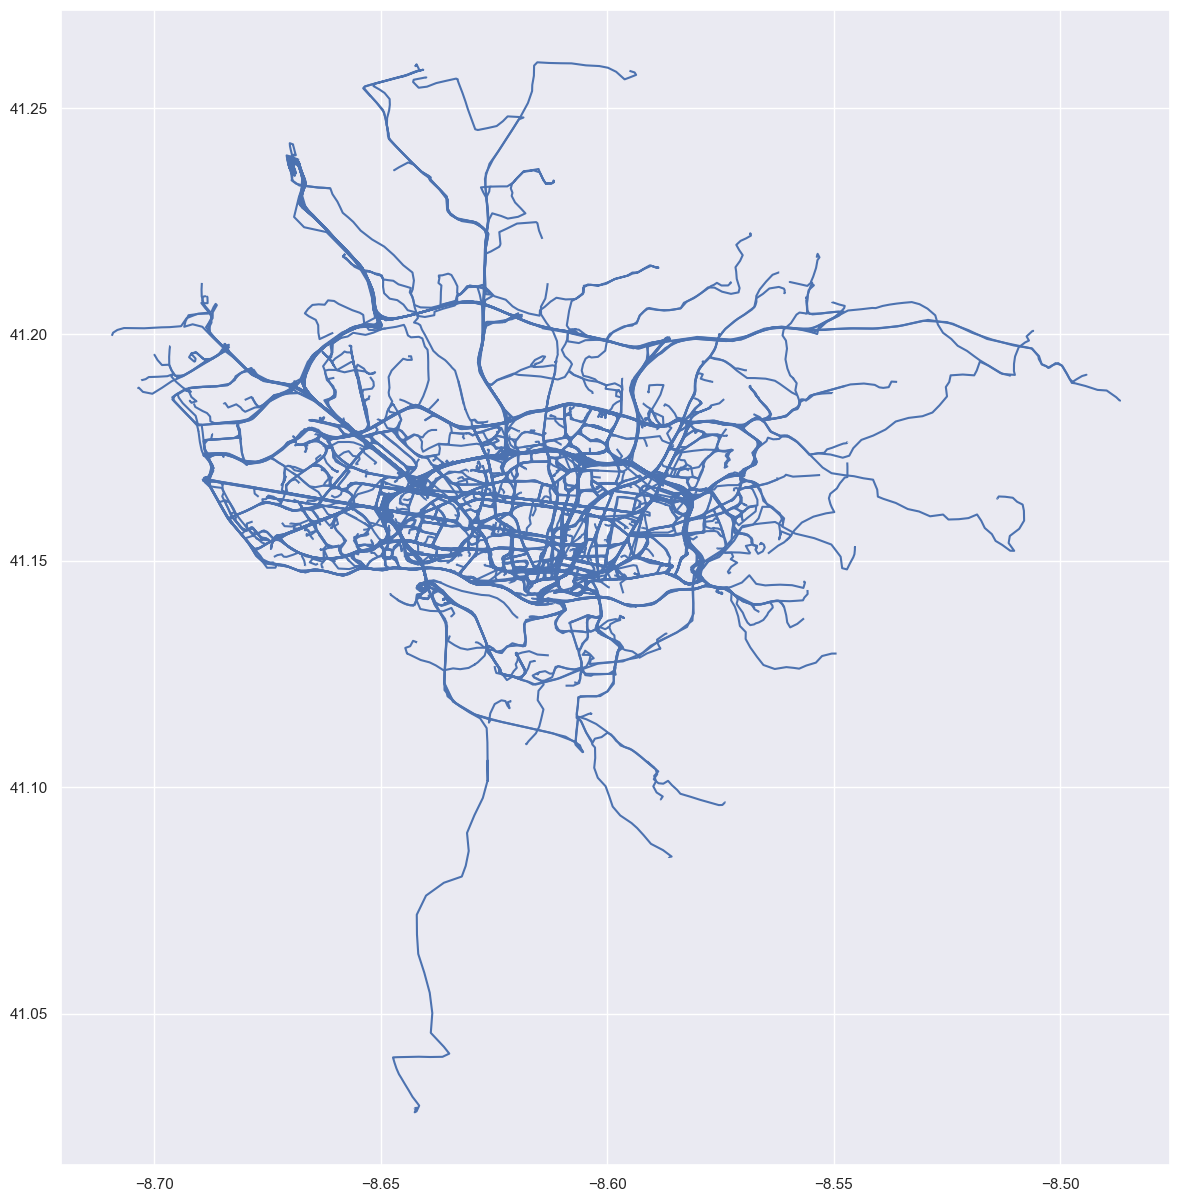

In [ ]:
df[~bad_routes].lines.plot(figsize=[15,15]);

Nice! In general, this seems to do a pretty good job of detecting outlier GPS segments. In some cases it may be a little too conservative (e.g. 629), but for the most part this does a good job. Of course, once we have a good estimate of the what points are invalid, there are plenty of options for further work:

1. What causes invalid points to appear? Are there tall buildings nearby?
2. How can we replace the invalid segments with good estimates of the actual location?
3. Do some taxis have a higher likelihood of having invalid points?
4. If the invalid route consists of multiple segments of similar duration, how do we pick the segment more likely to be the truth?
5. Does it improve results if we use the road network to estimate the distance between two points?

Some of these questions may require domain knowledge to answer (of which I have very little). The interesting thing about this approach is how little domain knowledge it requires. In other words, all we need is a way to estimate $\sigma$ between two GPS points, which means it can be applied to pretty much anything that generates GPS coordinates (hikers/bikers, regular cars, animal trackers, etc.).

In [ ]:
new_data = df[~bad_routes]
new_data.drop(['lines', 'traj'], axis=1, inplace=True)
new_data.to_csv('cleaned_data.csv', index=False)

C:\Users\vanbo\AppData\Local\Temp\ipykernel_9500\2463099027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop(['lines', 'traj'], axis=1, inplace=True)


In [ ]:
len(df[~bad_routes])

874